In [1]:
import nbodykit as nkit
import numpy as npy
from nbodykit.source.catalog import CSVCatalog
from nbodykit.source.catalog import ArrayCatalog
from matplotlib import pyplot
import healpy as hp
import pmesh
import time
import sys;
import dill as dl
from importlib import reload 
import scipy as scpy
sys.path.append("/home/chris/Dropbox/Document/Metric reconstruction/")

In [2]:
import lcmetric
import lcmetric.lightcone as lc
import lcmetric.utils as ut
import lcmetric.cgeodesic as geo
import lcmetric.lensing as lensing
import lcmetric.clcdensity as dens

# Set-up the initial cosmology

In [3]:
cone_dtype = npy.double # Data type for light-cone
NR = 430 # Radial resolution. NOTE: the actual size of any light-cone mesh field is NR+2 
NSIDE = 80 #Healpix nside
NPIX = 12 * NSIDE * NSIDE #Number of pixels

# In Mpc, to convert from Mpc h^-1, multiply cosmo_paras['h'] / L_unit
# H_0 is cosmo_paras['h'] * 100 with L_unit = 3e5
L_unit = 3e5 

N_snap = 256 #snapshot mesh resolution
N_samples = 256 #snapshot number of particles

origin = npy.array([0, 0, 0.0], dtype=cone_dtype) #light-cone origin


In [27]:
# Setting initial cosmic parameters
cosmo_paras={'h':0.69, 'Omega_m':0.31, 'Omega_L':0.69}
init_zel_z = 9 #Redshift where n-body simulation starts
init_z = 0.30014
init_a = 1/(1+init_z)
final_z = 0.03
final_a = 1/(1+final_z)
zel_z = 9
zel_a = 1/(1+zel_z)
# 1/H(z)
def Hint(z, cosmo_paras):
    return 1/(cosmo_paras['h']*100*npy.sqrt(cosmo_paras['Omega_m']*(1+z)**3 + cosmo_paras['Omega_L']))

# H(z)
def H(z, cosmo_paras):
    return (cosmo_paras['h']*100/(1+z)*npy.sqrt(cosmo_paras['Omega_m']*(1+z)**3 + cosmo_paras['Omega_L']))

# integrate 1/H(z) - r, to inversely solve z for given r
def inverse_Hint(z, r, cosmo_paras):
    return npy.abs(scpy.integrate.quad(Hint, 0, z,args=(cosmo_paras))[0] - r)

# Initial comoving distance
init_r = scpy.integrate.quad(Hint, 0, init_z,args=(cosmo_paras))[0]

# Final comoving distance
final_r = scpy.integrate.quad(Hint, 0, final_z,args=(cosmo_paras))[0]

# Initial Hubble
Hi = H(init_z, cosmo_paras)

#Final Hubble
Hf = H(final_z, cosmo_paras)
H0 = cosmo_paras['h'] * 100
L_snap = 512 / cosmo_paras['h'] / L_unit
def dl_dump(path, name, c):
    with open(path+name, 'wb') as f:
        dl.dump(c,f)
    f.close()

def dl_load(path, name):
    with open(path+name, 'rb') as f:
        temp = dl.load(f)
    f.close()
    return temp

In [5]:
# Working directory path
path='/home/chris/Desktop/code_test/'
# All snaps path
snaps_path = path+'gadget/cone_test_256_z0p*.[0-9]*'
# Initial snap path
init_snap_path = path+'gadget/cone_test_256_z0p300.[0-9]*'
# Final snap path
final_snap_path = path+'gadget/cone_test_256_z0p030.[0-9]*'
# Zel snap path
zel_snap_path = path+'gadget/cone_test_256_z9p*.[0-9]*'
# lc data path
lc_path = path+'raw_data/cone/cone_test_256_lightcone.[0-9]*'

In [7]:
lc=reload(lc)
ut=reload(ut)

# Read-in cone and snapshots data to generate light-cone in different ways

In [11]:
%%time
lc_relx = lc.LightconeFromCone(lc_path, init_snap_path, final_snap_path, origin, 
                        cosmo_paras, L_snap, N_snap, init_z, final_z, 
                        NR, NSIDE, zel_z, zel_snap_path, cone_type='UNFORMATTED',
                        snap_type='Gadget1', lensing_kappa=True)

Starting reading initial snap
Starting reading final snap
Starting reading lightcone data
Total light-cone files num is 464


/home/chris/Dropbox/Document/Metric reconstruction/lcmetric/lightcone.py:506: RuntimeWarning: invalid value encountered in true_divide
  vw /= counts


CPU times: user 40min 22s, sys: 1min 35s, total: 41min 57s
Wall time: 7min 46s


In [12]:
%%time
lc_depo = lc.LightconeFromConePhi(lc_path, origin, 
                        cosmo_paras, L_snap, N_snap, init_z, final_z, 
                        NR, NSIDE, zel_z, zel_snap_path, cone_type='UNFORMATTED',
                        snap_type='Gadget1')

Starting reading lightcone data
Total light-cone files num is 464


/home/chris/Dropbox/Document/Metric reconstruction/lcmetric/lightcone.py:277: RuntimeWarning: invalid value encountered in true_divide
  vw /= counts
/home/chris/Dropbox/Document/Metric reconstruction/lcmetric/lightcone.py:279: RuntimeWarning: invalid value encountered in true_divide
  Phi /= counts


CPU times: user 13min 24s, sys: 51.8 s, total: 14min 15s
Wall time: 4min 17s


In [13]:
%%time
lc_snaps_64 = lc.LightconeFromSnaps(snaps_path, 4, origin, 
                        cosmo_paras, L_snap, N_snap, -2, 1, 
                        NR, NSIDE, zel_z, zel_snap_path,
                        snap_type='Gadget1', NR_is_N_snap=True)

Initial snap is set at redshift 0.314761357
Final snap is set at redshift 0.0300000001
Setting the radial resolution NR as 64
64 0.004214983919960901 0.7605943045662528
63 0.004154932282563827 0.763387138859547
62 0.0040948807171900655 0.7661927666433842
61 0.004034829072480626 0.7690112979018375
60 0.003974777472619723 0.7718428488325125
59 0.0039147258607821886 0.7746875371477148
58 0.0038546742337845397 0.7775454756714268
57 0.003794622642895909 0.7804167901195589
56 0.0037345710315285644 0.7833015915289726
55 0.003674519435130921 0.7862000066652649
54 0.003614467793273251 0.7891121601170129
53 0.0035544161887520625 0.7920381725045192
52 0.003494364595916266 0.7949781692432958
51 0.003434312942853541 0.7979322829973495
50 0.0033742613658560047 0.8009006369621124
49 0.0033142097392233273 0.8038833648971822
48 0.0032541581461163144 0.806880599080968
47 0.003194106508682729 0.8098924718472593
46 0.003134054908123223 0.812919121345552
45 0.0030740032897101353 0.8159606824266182
44 0.003

In [14]:
%%time
lc_snaps_16 = lc.LightconeFromSnaps(snaps_path, 4, origin, 
                        cosmo_paras, L_snap, N_snap, -2, 0, 
                        NR, NSIDE, zel_z, zel_snap_path,
                        snap_type='Gadget1', NR_is_N_snap=True, need_reduce=True)

Initial snap is set at redshift 0.300143551
Final snap is set at redshift 0.0300000001
Setting the radial resolution NR as 16
16 0.004034829072480626 0.7691458380780777
15 0.003794622642895909 0.7800057780069608
14 0.0035544161887520625 0.7910612881271009
13 0.0033142097392233273 0.8023191840477901
12 0.0030740032897101353 0.8137866112449718
11 0.0028337968370132707 0.8254710570976942
10 0.0025935904142439727 0.8373803695533812
9 0.0023533839522840196 0.8495227787586758
8 0.0021131775069831125 0.8619069219287971
7 0.00187297103612394 0.8745418652119845
6 0.0016327646130445594 0.8874371305495687
5 0.0013925581417353493 0.9006027272026226
4 0.0011523517008807346 0.9140491733933291
3 0.0009121452620332465 0.9277875405308005
2 0.0006719388089886097 0.9418294746993542
1 0.00043173236440410763 0.9561872472615056
CPU times: user 2min 38s, sys: 11.9 s, total: 2min 50s
Wall time: 2min 16s


In [15]:
%%time
lc_snaps_relx_64 = lc.LightconeFromSnaps(snaps_path, 4, origin, 
                        cosmo_paras, L_snap, N_snap, -2, 1, 
                        NR, NSIDE, zel_z, zel_snap_path,
                        snap_type='Gadget1', lensing_kappa=True)

Initial snap is set at redshift 0.314761357
Final snap is set at redshift 0.0300000001
Starting reading initial snap
Starting reading final snap
-0.004214983919960901 6.005161840068069e-05 14951353
-0.004154932282563827 6.005163739707456e-05 14669155
-0.0040948807171900655 6.005156537376103e-05 14237606
-0.004034829072480626 6.005164470943968e-05 13792902
-0.003974777472619723 6.005159986090247e-05 13384117
-0.0039147258607821886 6.005161183753483e-05 13032447
-0.0038546742337845397 6.005162699764888e-05 12682174
-0.003794622642895909 6.005159088863076e-05 12200706
-0.0037345710315285644 6.005161136734454e-05 11689063
-0.003674519435130921 6.005159639764328e-05 11405281
-0.003614467793273251 6.005164185767008e-05 11021633
-0.0035544161887520625 6.005160452118852e-05 10751181
-0.003494364595916266 6.0051592835796714e-05 10391060
-0.003434312942853541 6.005165306272476e-05 9955115
-0.0033742613658560047 6.005157699753632e-05 9697281
-0.0033142097392233273 6.005162663267737e-05 9502892
-0

/home/chris/Dropbox/Document/Metric reconstruction/lcmetric/lightcone.py:770: RuntimeWarning: invalid value encountered in true_divide
  self.vw /= self.counts


CPU times: user 1h 26min 19s, sys: 2min 12s, total: 1h 28min 32s
Wall time: 10min 30s


In [8]:
%%time
lc_snaps_relx_16 = lc.LightconeFromSnaps(snaps_path, 4, origin, 
                        cosmo_paras, L_snap, N_snap, -2, 0, 
                        NR, NSIDE, zel_z, zel_snap_path,
                        snap_type='Gadget1', lensing_kappa=True, need_reduce=True)

Initial snap is set at redshift 0.300143551
Final snap is set at redshift 0.0300000001
Starting reading initial snap
Starting reading final snap
-0.004034829072480626 0.00024020646588095596 57647661
-0.003794622642895909 0.00024020642958471694 51296336
-0.0035544161887520625 0.00024020645414384641 44864461
-0.0033142097392233273 0.00024020644952873517 39543622
-0.0030740032897101353 0.00024020644951319205 34399250
-0.0028337968370132707 0.00024020645269686456 29761193
-0.0025935904142439727 0.00024020642276929806 24797870
-0.0023533839522840196 0.00024020646195995312 20513479
-0.0021131775069831125 0.000240206445300907 16343748
-0.00187297103612394 0.00024020647085917259 13104765
-0.0016327646130445594 0.00024020642307938053 10115721
-0.0013925581417353493 0.00024020647130921016 7703419
-0.0011523517008807346 0.00024020644085461472 5604608
-0.0009121452620332465 0.00024020643884748805 3621283
-0.0006719388089886097 0.00024020645304463682 2175754
-0.00043173236440410763 0.00024020644458

/home/chris/Dropbox/Document/Metric reconstruction/lcmetric/lightcone.py:770: RuntimeWarning: invalid value encountered in true_divide
  self.vw /= self.counts


CPU times: user 1h 1min 49s, sys: 1min 33s, total: 1h 3min 23s
Wall time: 7min 13s


In [16]:
lc_relx.build_lcmetric()

Starting v-cycle 1
    At level 0, after 16 relaxations


/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


    Max error for field Phi is 11817.418406201756 at step 63
    Relative error of the L2 norm is 0.5052081752261022
Starting v-cycle 2
    At level 0, after 16 relaxations
    Max error for field Phi is 3255.217270144982 at step 313
    Relative error of the L2 norm is 0.1992704568659831
Starting v-cycle 3
    At level 0, after 16 relaxations
    Max error for field Phi is 1425.4857904672742 at step 342
    Relative error of the L2 norm is 0.10517308031293911
Starting v-cycle 4
    At level 0, after 16 relaxations
    Max error for field Phi is 774.6720546526345 at step 344
    Relative error of the L2 norm is 0.06286682167930445
Starting v-cycle 5
    At level 0, after 16 relaxations
    Max error for field Phi is 484.65900076483257 at step 343
    Relative error of the L2 norm is 0.04060455132393442
Starting v-cycle 6
    At level 0, after 16 relaxations
    Max error for field Phi is 327.11397131177426 at step 341
    Relative error of the L2 norm is 0.02771207285557996
Starting v-

In [17]:
lc_snaps_relx_64.build_lcmetric()


Starting v-cycle 1
    At level 0, after 16 relaxations
    Max error for field Phi is 10928.18486097069 at step 60
    Relative error of the L2 norm is 0.49921047441489347
Starting v-cycle 2
    At level 0, after 16 relaxations
    Max error for field Phi is 3253.901291552587 at step 332
    Relative error of the L2 norm is 0.1979341306928477
Starting v-cycle 3
    At level 0, after 16 relaxations
    Max error for field Phi is 1414.9286081990367 at step 340
    Relative error of the L2 norm is 0.10478646341568239
Starting v-cycle 4
    At level 0, after 16 relaxations
    Max error for field Phi is 800.535344183118 at step 341
    Relative error of the L2 norm is 0.06274780515511237
Starting v-cycle 5
    At level 0, after 16 relaxations
    Max error for field Phi is 480.7929192886603 at step 340
    Relative error of the L2 norm is 0.04054418247520778
Starting v-cycle 6
    At level 0, after 16 relaxations
    Max error for field Phi is 301.66088144650945 at step 340
    Relative e

In [18]:
lc_snaps_relx_16.build_lcmetric()

Starting v-cycle 1
    At level 0, after 16 relaxations
    Max error for field Phi is 11816.137051479931 at step 63
    Relative error of the L2 norm is 0.5053255069993422
Starting v-cycle 2
    At level 0, after 16 relaxations
    Max error for field Phi is 3255.392799511293 at step 313
    Relative error of the L2 norm is 0.19931465695325715
Starting v-cycle 3
    At level 0, after 16 relaxations
    Max error for field Phi is 1425.6527736247806 at step 342
    Relative error of the L2 norm is 0.10519792994150756
Starting v-cycle 4
    At level 0, after 16 relaxations
    Max error for field Phi is 774.7247411135772 at step 344
    Relative error of the L2 norm is 0.0628834921612963
Starting v-cycle 5
    At level 0, after 16 relaxations
    Max error for field Phi is 484.6796549311171 at step 343
    Relative error of the L2 norm is 0.04061725036879527
Starting v-cycle 6
    At level 0, after 16 relaxations
    Max error for field Phi is 327.11101931152996 at step 341
    Relative 

# Save / load data

In [47]:
lc_relx.NR

430

In [91]:
dl_dump(path, 'lc_depo', lc_depo)


In [59]:
dl_dump(path, 'lc_relx', lc_relx)
dl_dump(path, 'lc_snaps_16', lc_snaps_16)
dl_dump(path, 'lc_snaps_64', lc_snaps_64)

In [65]:

dl_dump(path, 'lc_snaps_relx_16', lc_snaps_relx_16)
dl_dump(path, 'lc_snaps_relx_64', lc_snaps_relx_64)

In [ ]:
lc_relx = dl_load(path, 'lc_relx')
depo = dl_load(path, 'lc_depo')

lc_snaps_16 = dl_load(path, 'lc_snaps_16')
lc_snaps_64 = dl_load(path, 'lc_snaps_64')
lc_snaps_relx_16 = dl_load(path, 'lc_snaps_relx_16')
lc_snaps_relx_64 = dl_load(path, 'lc_snaps_relx_64')

# Generating lensing data

In [89]:
def born_lensing(lc, r):
    born_lensing =  lensing.Lensing(lc.met, lc.init_r, lc.final_r, 
                             lc.NR, lc.NSIDE, mode = 'born_approx_snap')
    born_lensing.set_sources(init_with_hp_tars=True, r=0.004)
    return born_lensing.calculate()
def bins_lensing(lc1, r):
    bins = lensing.Lensing(lc1.met, lc1.init_r, lc1.final_r, lc1.NR, lc1.NSIDE, 
                               mode = 'born_approx_lc', kappa1=lc1.kappa1, kappa2=lc1.kappa2,
                               L_snap=lc1.L_snap, N_snap_part=lc1.N_snap_part)
    bins.set_sources(init_with_hp_tars=True, r=0.004)
    
    return bins.calculate()

In [95]:
da_born_relx =  born_lensing(lc_relx, 0.004)
da_born_depo =  born_lensing(lc_depo, 0.004)

/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/chris/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [67]:
da_born_snaps_16 =  born_lensing(lc_snaps_16, 0.004)
da_born_snaps_64 =  born_lensing(lc_snaps_64, 0.004)

In [68]:
da_born_snaps_relx_16 =  born_lensing(lc_snaps_relx_16, 0.004)
da_born_snaps_relx_64 =  born_lensing(lc_snaps_relx_64, 0.004)

In [101]:
da_bins_relx = bins_lensing(lc_relx, 0.004)
da_bin_snaps_relx_16 =  bins_lensing(lc_snaps_relx_16, 0.004)
da_bin_snaps_relx_64 =  bins_lensing(lc_snaps_relx_64, 0.004)

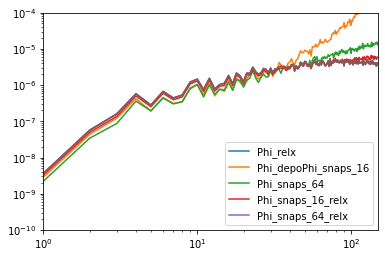

In [99]:
pyplot.plot(hp.sphtfunc.anafast(da_born_relx , lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1)  ) 
pyplot.plot(hp.sphtfunc.anafast(da_born_depo , lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1)  ) 

pyplot.plot(hp.sphtfunc.anafast(da_born_snaps_16, lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1))
pyplot.plot(hp.sphtfunc.anafast(da_born_snaps_64, lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1))


pyplot.plot(hp.sphtfunc.anafast(da_born_snaps_relx_16, lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1))
pyplot.plot(hp.sphtfunc.anafast(da_born_snaps_relx_64, lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1))


pyplot.legend(['Phi_relx', 'Phi_depo' 'Phi_snaps_16', 'Phi_snaps_64','Phi_snaps_16_relx', 'Phi_snaps_64_relx'])

pyplot.xlim(1,150)
pyplot.ylim(1e-10,1e-4)
pyplot.yscale('log')
pyplot.xscale('log')

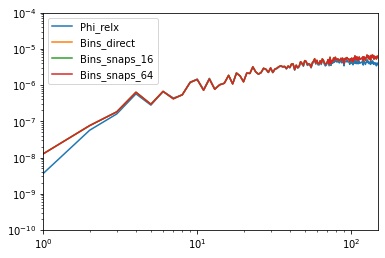

In [107]:
pyplot.plot(hp.sphtfunc.anafast(da_born_relx , lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1)  ) 
pyplot.plot(hp.sphtfunc.anafast(da_bins_relx , lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1)  ) 
pyplot.plot(hp.sphtfunc.anafast(da_bin_snaps_relx_16 , lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1)  ) 
pyplot.plot(hp.sphtfunc.anafast(da_bin_snaps_relx_64, lmax = 150)* npy.array(range(151)) * (npy.array(range(151)) + 1))

pyplot.legend(['Phi_relx', 'Bins_direct', 'Bins_snaps_16', 'Bins_snaps_64'])

pyplot.xlim(1,150)
pyplot.ylim(1e-10,1e-4)
pyplot.yscale('log')
pyplot.xscale('log')

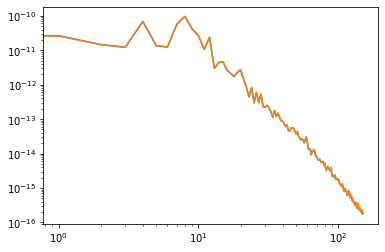

In [24]:
pyplot.plot(hp.sphtfunc.anafast(lc_relx.met.sols['Phi'][410], lmax = 150))
#pyplot.plot(hp.sphtfunc.anafast(lc2.met.sols['Phi'][300], lmax = 150))
pyplot.plot(hp.sphtfunc.anafast(lc_snaps_relx_16.met.sols['Phi'][410], lmax = 150))

#pyplot.plot(hp.sphtfunc.anafast(lc_snaps_relx_64.met.sols['Phi'][410], lmax = 150))

pyplot.xscale('log')
pyplot.yscale('log')

In [85]:
ut=reload(ut)

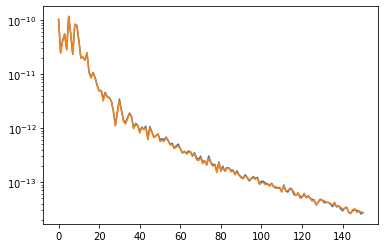

In [106]:
pyplot.plot(hp.sphtfunc.anafast(ut.interp_lc(lc_relx.met.sols['Phi'], 0.004, lc_relx.final_r, 
          (lc_relx.init_r - lc_relx.final_r) / lc_relx.NR) , lmax = 150))
pyplot.plot(hp.sphtfunc.anafast(ut.interp_lc(temp.met.sols['Phi'], 0.004, temp.final_r, 
          (temp.init_r - temp.final_r) / temp.NR) , lmax = 150))
#pyplot.xscale('log')
pyplot.yscale('log')

(0.95, 1.05)

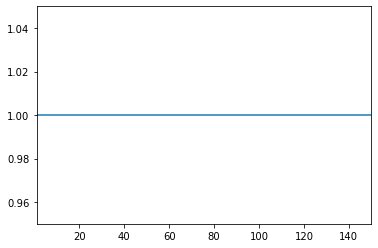

In [105]:
pyplot.plot(hp.sphtfunc.anafast(temp.met.sols['Phi'][180], lmax = 150)/
           hp.sphtfunc.anafast(lc1.met.sols['Phi'][180], lmax = 150))
pyplot.xlim(1,150)
pyplot.ylim(0.95,1.05)